In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
movies=pd.read_csv('movie.csv')
tags=pd.read_csv('tag.csv')
ratings=pd.read_csv('rating.csv')
gen_tags=pd.read_csv('genome_tags.csv')
gen_score=pd.read_csv('genome_scores.csv')
movies
tags

,userId,movieId,tag,timestamp
0,18,4141,Mark Waters,2009-04-24 18:19:40
1,65,208,dark hero,2013-05-10 01:41:18
2,65,353,dark hero,2013-05-10 01:41:19
3,65,521,noir thriller,2013-05-10 01:39:43
4,65,592,dark hero,2013-05-10 01:41:18
...,...,...,...,...
465559,138446,55999,dragged,2013-01-23 23:29:32
465560,138446,55999,Jason Bateman,2013-01-23 23:29:38
465561,138446,55999,quirky,2013-01-23 23:29:38
465562,138446,55999,sad,2013-01-23 23:29:32


In [3]:
#Checking out the null values in different dataframes
print('movies')
print(movies.isnull().sum())
print('               ')
print('tags')
print(tags.isnull().sum())
print('               ')
print('ratings')
print(ratings.isnull().sum())
print('               ')
print('genome_tags')
print(gen_tags.isnull().sum())


movies
movieId    0
title      0
genres     0
dtype: int64
               
tags
userId        0
movieId       0
tag          16
timestamp     0
dtype: int64
               
ratings
userId       0
movieId      0
rating       0
timestamp    0
dtype: int64
               
genome_tags
tagId    0
tag      0
dtype: int64


<AxesSubplot:>

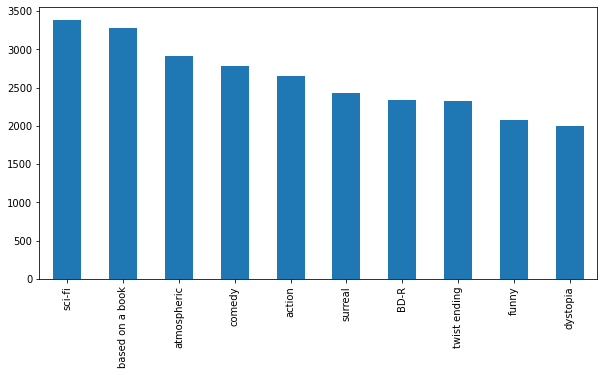

In [3]:
#Finding the frequeny of different tags associated with each movie
tag_counts=tags['tag'].value_counts()
tag_counts[:10].plot(kind='bar', figsize=(10,5))

In [6]:
movies.sort_values(by='movieId', inplace=True)
ratings.sort_values(by='movieId', inplace=True)

#Extracting year from the title of movies
movies['year'] = movies.title.str.extract("\((\d{4})\)", expand=True)
movies.year = pd.to_datetime(movies.year, format='%Y')
movies.year = movies.year.dt.year 
#Removing the year from movie titles
movies.title = movies.title.str[:-7]

# Categorize movies genres properly. Working later with +20MM rows of strings proved very resource consuming
genres_unique = pd.DataFrame(movies.genres.str.split('|').tolist()).stack().unique()
genres_unique = pd.DataFrame(genres_unique, columns=['genre']) # Format into DataFrame to store later
movies = movies.join(movies.genres.str.get_dummies().astype(bool))
movies.drop('genres', inplace=True, axis=1)

#Modifying the timestamp of ratings to the year
ratings.timestamp = pd.to_datetime(ratings.timestamp, infer_datetime_format=True)
ratings.timestamp = ratings.timestamp.dt.year

#Removing if any null values are present
movies.dropna(inplace=True)
ratings.dropna(inplace=True)


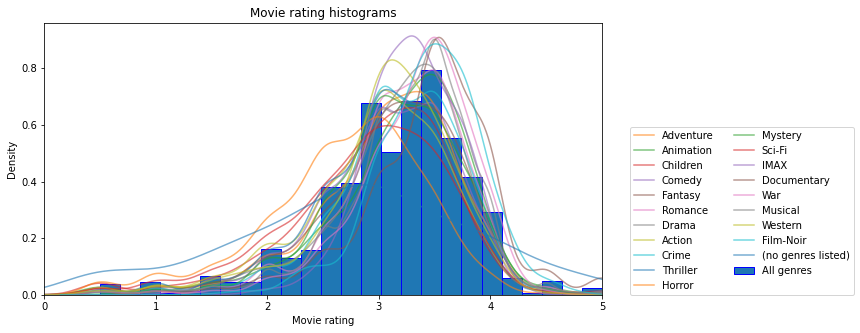

In [24]:
mov_tmp = ratings[['movieId','rating']].groupby('movieId').mean()

mov_tmp.hist(bins=25, grid=False, edgecolor='b',density=True,label ='All genres', figsize=(10,5))
# Ploting histograms per genre
for genre in genres_unique.genre:
    mov_tmp = movies[movies[genre]==True]
    mov_tmp = ratings[ratings.set_index('movieId').index.isin(mov_tmp.set_index('movieId').index)]
    mov_tmp = mov_tmp[['movieId','rating']].groupby('movieId').mean()
    mov_tmp.rating.plot(grid=False, alpha=0.6, kind='kde', label=genre)

plt.legend(loc=(1.05,0), ncol=2)
plt.xlim(0,5)
plt.xlabel('Movie rating')
plt.title('Movie rating histograms')
plt.show()

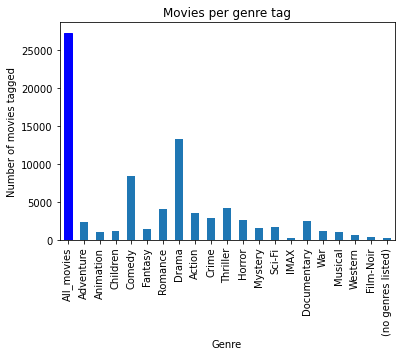

In [25]:
mov_tmp = movies[['movieId', 'year']].groupby('year')
df = pd.DataFrame({'All_movies' : mov_tmp.movieId.nunique().cumsum()})
# Plot histogram for each individual genre

for genre in genres_unique.genre:
    mov_tmp = movies[movies[genre]][['movieId', 'year']].groupby('year')
    df[genre]=mov_tmp.movieId.nunique().cumsum()

df.fillna(method='ffill', inplace=True)
barlist = df.iloc[-1].plot.bar()
barlist.patches[0].set_color('b') # Color 'All_movies' differently, as it's not a genre tag count
plt.xticks(rotation='vertical')
plt.title('Movies per genre tag')
plt.xlabel('Genre')
plt.ylabel('Number of movies tagged')
plt.show()


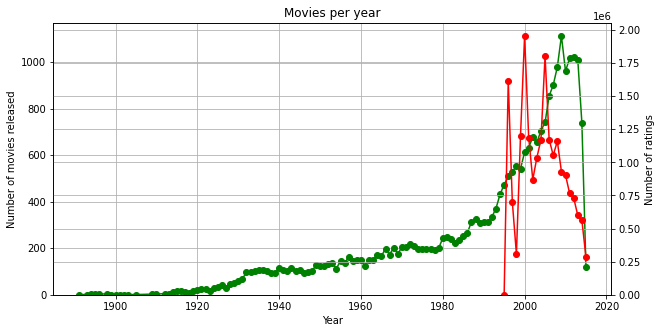

In [23]:
dftmp = movies[['movieId', 'year']].groupby('year')

fig, ax1 = plt.subplots(figsize=(10,5))
ax1.plot(dftmp.year.first(), dftmp.movieId.nunique(), "g-o")
ax1.grid(None)
ax1.set_ylim(0,)

dftmp = ratings[['rating', 'timestamp']].groupby('timestamp')
ax2 = ax1.twinx()
ax2.plot(dftmp.timestamp.first(), dftmp.rating.count(), "r-o")
ax2.grid(None)
ax2.set_ylim(0,)

ax1.set_xlabel('Year')
ax1.set_ylabel('Number of movies released'); ax2.set_ylabel('Number of ratings')
plt.title('Movies per year')
plt.show()